## OBJECTIVE : 
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

## Importing Libraries & getting Data

In [1]:
import numpy as np 
import pandas as pd 
import sqlite3 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
import math 
import os 
import string 
from tqdm import tqdm 

import warnings 
warnings.filterwarnings('ignore')

# Metrics libraries
from sklearn.metrics import accuracy_score ,confusion_matrix, roc_curve, auc ,roc_auc_score

# NLP libraries 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.python.client import device_lib

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())


Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11144832516523315930
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1753127323
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4523458332752107240
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
connection = sqlite3.connect('G:/My Drive/datasets/amazon food review/dataset/database.sqlite')

In [5]:
# ignoring datapoints where score = 3 (neutral review)

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
LIMIT 100000
""", connection)

In [6]:
# label encoding score into positive (x>3) and negative (x<3)

def partition(x):
    if x < 3:
        return 0
    else:
        return 1
        
score_with_neutral = filtered_data['Score']
score_wo_neutral = score_with_neutral.map(partition)

filtered_data['Score'] = score_wo_neutral


In [7]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             100000 non-null  object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 100000 non-null  object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [9]:
filtered_data.shape

(100000, 10)

## Data Cleaning 

In [10]:
display = pd.read_sql_query("""
SELECT UserId, ProductId ,ProfileName ,Time, Score ,Text ,COUNT(*)
FROM Reviews 
GROUP BY UserId 
HAVING COUNT(*) > 1
""", connection)

In [11]:
display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [12]:
display.shape

(80668, 7)

In [13]:
display['COUNT(*)'].sum()

393063

In [14]:
display = pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score != 3 AND UserId='#oc-R11D9D7SHXIJB9'
ORDER BY ProductId
""", connection)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


#### NOTE : 
- It can be seen that same user has multiple reviews with same values for all the parameters.

- So, in order to get unbiased results ,we need to remove the rows having same parameters.

- Steps to do so : 
    - first sort the data according to ProductId in ascending order.
    - Then just keep the first similar product review and delete the others.


In [15]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [16]:
clean_data = sorted_data.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)

clean_data.shape

(87775, 10)

## Data Preprocessing

#### Steps : 

1. Begin by removing the HTML tags

2. Remove any punctuations or limited set of special characters like , or . etc

3. Check if the word is made up of english letters and is not alpha-numeric.

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the words to lowercase

6. Remove Stopwords

7. Stemming the word 


In [17]:
# sample reviews

review_1 = clean_data['Text'].values[0]
print(review_1)
print('---------------------------------------')

review_2 = clean_data['Text'].values[1]
print(review_2)
print('---------------------------------------')

review_3 = clean_data['Text'].values[2]
print(review_3)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
---------------------------------------
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
---------------------------------------
I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attrac

### 1. Removing URLs


In [18]:
review_1 = re.sub('http\S+', "", review_1)
review_2 = re.sub('http\S+', "", review_2)
review_3 = re.sub('http\S+', "", review_3)


### 2. Removing HTML tags


In [19]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(review_1, 'lxml')
review_1 = soup.get_text()

soup = BeautifulSoup(review_2, 'lxml')
review_2 = soup.get_text()

soup = BeautifulSoup(review_3, 'lxml')
review_3 = soup.get_text()


### 3. Removing Apostrophes


In [20]:
def removing_apostrophes(text):
    # general
    text = re.sub("n\'t", " not", text)
    text = re.sub("\'re", " are", text)
    text = re.sub("\'s", " is", text)
    text = re.sub("\'d", " would", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("\'t", " not", text)
    text = re.sub("\'ve", " have", text)
    text = re.sub("\'m", " am", text)

    text = re.sub("won't", "will not", text)
    text = re.sub("can\'t", "can not", text)

    return text

# isn't gets converted to 'is not' in line 3
review_3 = removing_apostrophes(review_3)
print(review_3)


I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass... but still it did nothing to get them stuck. And then I actually saw a second fly land on it once, and I watched as it flapped it is wings frantically and within 30 secs it had unstuck itself!!!! This product was a total waste of money!


### 4. Removing Numbers / Punctuations /Special Characters

In [21]:
# removing numbers
review_1 = re.sub('\S*\d\S*', "", review_1).strip()
print(review_1)
print('-----------------------------------------')

# removing special characters
review_3 = re.sub('[^A-Za-z0-9]+', ' ', review_3)
print(review_3)


My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
-----------------------------------------
I had an infestation of fruitflies they were literally everywhere flying around me in my kitchen so I bought this product hoping to at least get rid of a few But after 2 weeks only 1 fly had stuck I was going around with a notepad and squishing the buggers myself with a success rate of 2 3 a day so clearly this product was useless I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass but still it did nothing to get them stuck And then I actually saw a second fly land on it once and I watched as it flapped it is wings frantically and within 30

### 5. Removing Stopwords

In [22]:
# removing the following words from the stop words list: 'no', 'nor', 'not'

stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
                 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
                 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
                 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
                 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                 "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                 "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                 'won', "won't", 'wouldn', "wouldn't"])


### Combining all Steps

In [23]:
from tqdm import tqdm
preprocessed_reviews = []

for text in tqdm(clean_data['Text'].values):
    text = re.sub('http\S+', "", text)
    text = BeautifulSoup(text, 'lxml').get_text()

    text = removing_apostrophes(text)

    text = re.sub('\S*\d\S*', "", text).strip()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)

    text = ' '.join(i.lower()
                    for i in text.split() if i.lower() not in stopwords)

    preprocessed_reviews.append(text.strip())

100%|██████████| 87775/87775 [00:46<00:00, 1905.30it/s]


## Splitting into train, test & validation sets


In [24]:
X = preprocessed_reviews
y = np.array(clean_data['Score'])

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# Models

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.calibration import CalibratedClassifierCV


## 1. Linear SVM - BoW

In [27]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_val_bow = vectorizer.transform(X_val)

scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow = scaler.transform(X_test_bow)
X_val_bow = scaler.transform(X_val_bow)


### 1.1 Hyperparameter Tuning

In [28]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
penalties = ['l1' ,'l2']

parameter_grid = {'penalty': penalties, 'alpha':alpha}

In [29]:
model = SGDClassifier(loss='hinge')

linear_bow_model = HalvingGridSearchCV(model ,parameter_grid ,scoring='roc_auc',cv=10 ,verbose=3)

linear_bow_model.fit(X_train_bow ,y_train)
print('Best Hyperparameters --> ', linear_bow_model.best_params_)
print('Best Accuracy --> ',linear_bow_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4778
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 4778
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END alpha=0.0001, penalty=l1;, score=(train=1.000, test=0.732) total time=   0.6s
[CV 2/10] END alpha=0.0001, penalty=l1;, score=(train=1.000, test=0.774) total time=   0.4s
[CV 3/10] END alpha=0.0001, penalty=l1;, score=(train=1.000, test=0.735) total time=   0.4s
[CV 4/10] END alpha=0.0001, penalty=l1;, score=(train=1.000, test=0.761) total time=   0.5s
[CV 5/10] END alpha=0.0001, penalty=l1;, score=(train=1.000, test=0.776) total time=   0.3s
[CV 6/10] END alpha=0.0001, penalty=l1;, score=(train=1.000, test=0.729) total time=   0.2s
[CV 7/10] END alpha=0.0001, penalty=l1;, score=(train=1.000, test=0.783) total time=   1.2s
[CV 8/10] END alpha=0.0001, penalty=l1;, score=(train=1.000, test=0.738) total time=   0.4

### 1.2 Model Building (Linear-BoW)

In [30]:
model_linear_bow = SGDClassifier(alpha=linear_bow_model.best_estimator_.alpha ,penalty=linear_bow_model.best_estimator_.penalty)

model_linear_bow.fit(X_train_bow, y_train)

# predicted values for train & test data
y_pred_bow = model_linear_bow.decision_function(X_train_bow)
y_pred_bow_test = model_linear_bow.decision_function(X_test_bow)

### 1.3 Model Evaluation (Linear-BoW)

In [31]:
print('Accuracy of Linear-BoW model : ', model_linear_bow.score(X_test_bow, y_test))

Accuracy of Linear-BoW model :  0.9016822997759465


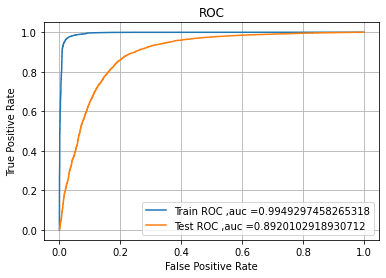

In [32]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_pred_bow)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_bow_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(
    str(roc_auc_score(y_train, y_pred_bow))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(
    str(roc_auc_score(y_test, y_pred_bow_test))))

plt.title('ROC')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

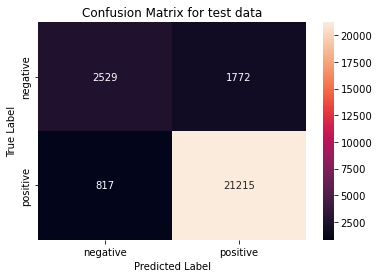

In [33]:
# confusion Matrix for test data
y_pred_bow_test = model_linear_bow.predict(X_test_bow)

confusion = confusion_matrix(y_test, y_pred_bow_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 1.4 Feature Importance (Linear-BoW)

In [34]:
features = vectorizer.get_feature_names_out()
coefs = model_linear_bow.coef_.reshape(-1, 1)

dataframe = pd.DataFrame(coefs, columns=['Coefficient'], index=features)

top_positive = dataframe.sort_values(by='Coefficient', ascending=False).head(10)
top_negative = dataframe.sort_values(by='Coefficient', ascending=True).head(10)

print('Top 10 positive features --> ')
print(top_positive)
print('----------------------------------------')
print('Top 10 negative features --> ')
print(top_negative)


Top 10 positive features --> 
           Coefficient
great         0.189010
good          0.144284
love          0.133865
best          0.126127
delicious     0.103880
loves         0.092178
excellent     0.084578
favorite      0.081131
nice          0.080702
perfect       0.079001
----------------------------------------
Top 10 negative features --> 
               Coefficient
not              -0.090836
terrible         -0.074375
disappointed     -0.073399
worst            -0.069867
awful            -0.065271
disappointing    -0.063690
horrible         -0.062947
threw            -0.058549
unfortunately    -0.056504
waste            -0.053395


## 2. Linear SVM - TFIDF

In [35]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_val)


### 2.1 Hyperparameter Tuning


In [36]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
penalties = ['l1', 'l2']

parameter_grid = {'penalty': penalties, 'alpha': alpha}

In [37]:
model = SGDClassifier(loss='hinge')

linear_tfidf_model = HalvingGridSearchCV(model, parameter_grid, scoring='roc_auc', cv=10, verbose=3)

linear_tfidf_model.fit(X_train_tfidf, y_train)
print('Best Hyperparameters --> ', linear_tfidf_model.best_params_)
print('Best Accuracy --> ', linear_tfidf_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4778
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 4778
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END alpha=0.0001, penalty=l1;, score=(train=0.966, test=0.912) total time=   0.0s
[CV 2/10] END alpha=0.0001, penalty=l1;, score=(train=0.965, test=0.915) total time=   0.0s
[CV 3/10] END alpha=0.0001, penalty=l1;, score=(train=0.962, test=0.913) total time=   0.0s
[CV 4/10] END alpha=0.0001, penalty=l1;, score=(train=0.960, test=0.910) total time=   0.0s
[CV 5/10] END alpha=0.0001, penalty=l1;, score=(train=0.958, test=0.900) total time=   0.0s
[CV 6/10] END alpha=0.0001, penalty=l1;, score=(train=0.966, test=0.927) total time=   0.0s
[CV 7/10] END alpha=0.0001, penalty=l1;, score=(train=0.959, test=0.855) total time=   0.0s
[CV 8/10] END alpha=0.0001, penalty=l1;, score=(train=0.954, test=0.903) total time=   0.0

### 2.2 Model Building (Linear-TFIDF)


In [38]:
model_linear_tfidf = SGDClassifier(
    alpha=linear_tfidf_model.best_estimator_.alpha, penalty=linear_tfidf_model.best_estimator_.penalty)

model_linear_tfidf.fit(X_train_tfidf, y_train)

# predicted values for train & test data
y_pred_tfidf = model_linear_tfidf.decision_function(X_train_tfidf)
y_pred_tfidf_test = model_linear_tfidf.decision_function(X_test_tfidf)

### 2.3 Model Evaluation (Linear-TFIDF)


In [39]:
print('Accuracy of Linear-TFIDF model : ',model_linear_tfidf.score(X_test_tfidf, y_test))

Accuracy of Linear-TFIDF model :  0.8909733034595375


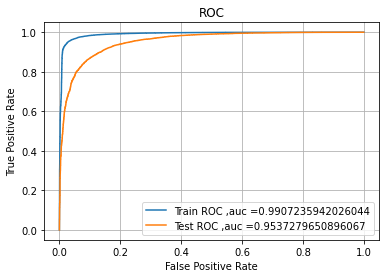

In [40]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_pred_tfidf)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_tfidf_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1,label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_tfidf))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test, y_pred_tfidf_test))))

plt.title('ROC')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

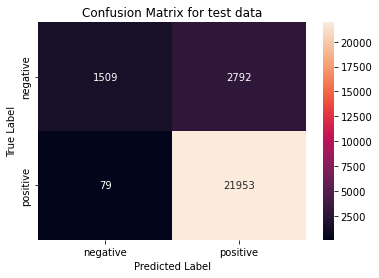

In [41]:
# confusion Matrix for test data
y_pred_tfidf_test = model_linear_tfidf.predict(X_test_tfidf)

confusion = confusion_matrix(y_test, y_pred_tfidf_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 2.4 Feature Importance (Linear-TFIDF)


In [42]:
features = vectorizer.get_feature_names_out()
coefs = model_linear_tfidf.coef_.reshape(-1, 1)

dataframe = pd.DataFrame(coefs, columns=['Coefficient'], index=features)

top_positive = dataframe.sort_values(
    by='Coefficient', ascending=False).head(10)
top_negative = dataframe.sort_values(by='Coefficient', ascending=True).head(10)

print('Top 10 positive features --> ')
print(top_positive)
print('----------------------------------------')
print('Top 10 negative features --> ')
print(top_negative)

Top 10 positive features --> 
                  Coefficient
great                3.257127
best                 2.474821
delicious            2.398874
good                 2.378511
not disappointed     2.179814
nice                 1.935781
love                 1.912358
perfect              1.832223
loves                1.754713
excellent            1.647910
----------------------------------------
Top 10 negative features --> 
              Coefficient
disappointed    -3.959183
worst           -3.648263
horrible        -3.451689
not buy         -3.361303
terrible        -3.139190
awful           -3.115153
threw           -2.974731
return          -2.969094
not             -2.856031
not worth       -2.808288


## 3. Linear SVM - AVG-W2V

In [43]:
#word2vec for train data

sent_list_train = []
sent_vectors_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())

w2v_model = Word2Vec(sent_list_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_train.append(sent_vectors)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 43009/43009 [00:42<00:00, 1019.06it/s]

43009
50


In [44]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []
sent_vectors_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_val.append(sent_vectors)

print(len(sent_vectors_val))
print(len(sent_vectors_val[0]))

100%|██████████| 18433/18433 [00:18<00:00, 993.36it/s]

18433
50


In [45]:
#word2vec for test data

sent_list_test = []
sent_vectors_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

for sent in tqdm(sent_list_test):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_test.append(sent_vectors)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 26333/26333 [00:26<00:00, 1007.14it/s]

26333
50


In [46]:
X_train_avg_w2v = sent_vectors_train
X_val_avg_w2v = sent_vectors_val
X_test_avg_w2v = sent_vectors_test

### 3.1 Hyperparameter Tuning


In [47]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
penalties = ['l1' ,'l2']

parameter_grid = {'penalty': penalties, 'alpha':alpha}

In [48]:
model = SGDClassifier(loss='hinge')

linear_avg_w2v_model = HalvingGridSearchCV(model ,parameter_grid ,scoring='roc_auc',cv=10 ,verbose=3)

linear_avg_w2v_model.fit(X_train_avg_w2v ,y_train)
print('Best Hyperparameters --> ', linear_avg_w2v_model.best_params_)
print('Best Accuracy --> ',linear_avg_w2v_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4778
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 4778
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END alpha=0.0001, penalty=l1;, score=(train=0.894, test=0.920) total time=   0.0s
[CV 2/10] END alpha=0.0001, penalty=l1;, score=(train=0.876, test=0.853) total time=   0.0s
[CV 3/10] END alpha=0.0001, penalty=l1;, score=(train=0.901, test=0.910) total time=   0.0s
[CV 4/10] END alpha=0.0001, penalty=l1;, score=(train=0.904, test=0.863) total time=   0.0s
[CV 5/10] END alpha=0.0001, penalty=l1;, score=(train=0.899, test=0.865) total time=   0.0s
[CV 6/10] END alpha=0.0001, penalty=l1;, score=(train=0.885, test=0.897) total time=   0.0s
[CV 7/10] END alpha=0.0001, penalty=l1;, score=(train=0.894, test=0.897) total time=   0.0s
[CV 8/10] END alpha=0.0001, penalty=l1;, score=(train=0.904, test=0.881) total time=   0.0

### 3.2 Model Building (Linear-AVG-W2V)


In [49]:
model_linear_avg_w2v = SGDClassifier(alpha=linear_avg_w2v_model.best_estimator_.alpha ,penalty=linear_avg_w2v_model.best_estimator_.penalty)

model_linear_avg_w2v.fit(X_train_avg_w2v, y_train)

# predicted values for train & test data
y_pred_avg_w2v = model_linear_avg_w2v.decision_function(X_train_avg_w2v)
y_pred_avg_w2v_test = model_linear_avg_w2v.decision_function(X_test_avg_w2v)

### 3.3 Model Evaluation (Linear-AVG-W2V)


In [50]:
print('Accuracy of Linear-AVG-W2V model : ', model_linear_avg_w2v.score(X_test_avg_w2v, y_test))

Accuracy of Linear-AVG-W2V model :  0.8788592260661527


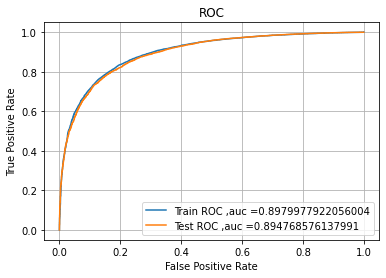

In [51]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_pred_avg_w2v)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_avg_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_avg_w2v))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test, y_pred_avg_w2v_test))))

plt.title('ROC')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

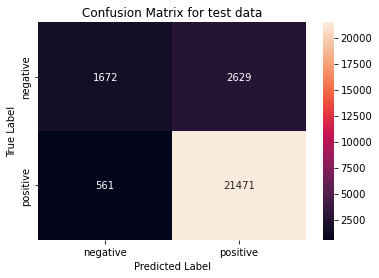

In [52]:
# confusion Matrix for test data
y_pred_avg_w2v_test = model_linear_avg_w2v.predict(X_test_avg_w2v)

confusion = confusion_matrix(y_test, y_pred_avg_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## 4. Linear SVM - TFIDF-W2V


In [53]:
sent_list_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())

w2v_model = Word2Vec(sent_list_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


tfidf_vectors = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_features=500)
tfidf_matrix = tfidf_vectors.fit_transform(X_train)

tfidf_features = tfidf_vectors.get_feature_names()
tfidf_dictionary = dict(zip(tfidf_vectors.get_feature_names(), list(tfidf_vectors.idf_)))


#word2vec for train data

tfidf_sent_vectors_train = []
row = 0

for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    weight_sum = 0

    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf)
            weight_sum += tfidf

    if weight_sum != 0:
        sent_vectors /= weight_sum

    tfidf_sent_vectors_train.append(sent_vectors)
    row += 1

100%|██████████| 43009/43009 [00:51<00:00, 833.51it/s]


In [54]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

tfidf_sent_vectors_val = []
row = 0

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_val.append(sent_vectors)
    row +=1

100%|██████████| 18433/18433 [00:22<00:00, 824.11it/s]


In [55]:
#word2vec for test data

sent_list_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

tfidf_sent_vectors_test = []
row=0
    
for sent in tqdm(sent_list_test):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_test.append(sent_vectors)
    row +=1

100%|██████████| 26333/26333 [00:33<00:00, 789.86it/s]


In [56]:
X_train_tfidf_w2v = tfidf_sent_vectors_train
X_val_tfidf_w2v = tfidf_sent_vectors_val
X_test_tfidf_w2v = tfidf_sent_vectors_test

### 4.1 Hyperparameter Tuning


In [57]:
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
penalties = ['l1', 'l2']

parameter_grid = {'penalty': penalties, 'alpha': alpha}

In [58]:
model = SGDClassifier(loss='hinge')

linear_tfidf_w2v_model = HalvingGridSearchCV(
    model, parameter_grid, scoring='roc_auc', cv=10, verbose=3)

linear_tfidf_w2v_model.fit(X_train_tfidf_w2v, y_train)
print('Best Hyperparameters --> ', linear_tfidf_w2v_model.best_params_)
print('Best Accuracy --> ', linear_tfidf_w2v_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4778
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 4778
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END alpha=0.0001, penalty=l1;, score=(train=0.816, test=0.794) total time=   0.0s
[CV 2/10] END alpha=0.0001, penalty=l1;, score=(train=0.832, test=0.828) total time=   0.0s
[CV 3/10] END alpha=0.0001, penalty=l1;, score=(train=0.848, test=0.846) total time=   0.0s
[CV 4/10] END alpha=0.0001, penalty=l1;, score=(train=0.826, test=0.773) total time=   0.0s
[CV 5/10] END alpha=0.0001, penalty=l1;, score=(train=0.805, test=0.842) total time=   0.0s
[CV 6/10] END alpha=0.0001, penalty=l1;, score=(train=0.831, test=0.795) total time=   0.0s
[CV 7/10] END alpha=0.0001, penalty=l1;, score=(train=0.834, test=0.806) total time=   0.0s
[CV 8/10] END alpha=0.0001, penalty=l1;, score=(train=0.842, test=0.844) total time=   0.0

### 4.2 Model Building (Linear-TFIDF-W2V)


In [59]:
model_linear_tfidf_w2v = SGDClassifier(
    alpha=linear_tfidf_w2v_model.best_estimator_.alpha, penalty=linear_tfidf_w2v_model.best_estimator_.penalty)

model_linear_tfidf_w2v.fit(X_train_tfidf_w2v, y_train)

# predicted values for train & test data
y_pred_tfidf_w2v = model_linear_tfidf_w2v.decision_function(X_train_tfidf_w2v)
y_pred_tfidf_w2v_test = model_linear_tfidf_w2v.decision_function(X_test_tfidf_w2v)

### 4.3 Model Evaluation (Linear-TFIDF-W2V)


In [60]:
print('Accuracy of Linear-TFIDF-W2V model : ',model_linear_tfidf_w2v.score(X_test_tfidf_w2v, y_test))

Accuracy of Linear-TFIDF-W2V model :  0.8366688185926404


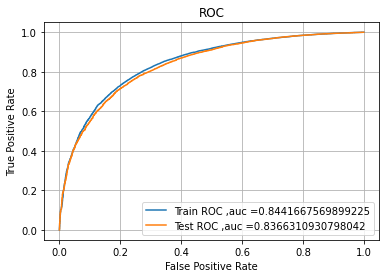

In [61]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(
    y_train, y_pred_tfidf_w2v)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(
    y_test, y_pred_tfidf_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(
    str(roc_auc_score(y_train, y_pred_tfidf_w2v))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(
    str(roc_auc_score(y_test, y_pred_tfidf_w2v_test))))

plt.title('ROC')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

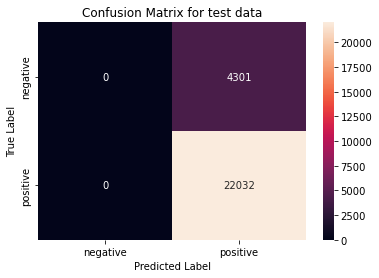

In [62]:
# confusion Matrix for test data
y_pred_tfidf_w2v_test = model_linear_tfidf_w2v.predict(X_test_tfidf_w2v)

confusion = confusion_matrix(y_test, y_pred_tfidf_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## RBF SVM

In [63]:
X = X[:40000]
y = y[:40000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)


## 5. RBF-SVM - BoW

In [64]:
vectorizer = CountVectorizer(min_df = 10, max_features = 500)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_val_bow = vectorizer.transform(X_val)

scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow = scaler.transform(X_test_bow)
X_val_bow = scaler.transform(X_val_bow)

### 5.1 Hyperparameter Tuning


In [65]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
parameter_grid = {'C':C}

In [66]:
model = SVC()

rbf_bow_model = HalvingGridSearchCV(model ,parameter_grid ,scoring='roc_auc',cv=10 ,verbose=3)

rbf_bow_model.fit(X_train_bow ,y_train)
print('Best Hyperparameters --> ', rbf_bow_model.best_params_)
print('Best Accuracy --> ',rbf_bow_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2177
max_resources_: 19600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 2177
Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END .....C=0.0001;, score=(train=0.636, test=0.712) total time=   0.1s
[CV 2/10] END .....C=0.0001;, score=(train=0.645, test=0.563) total time=   0.1s
[CV 3/10] END .....C=0.0001;, score=(train=0.656, test=0.563) total time=   0.1s
[CV 4/10] END .....C=0.0001;, score=(train=0.667, test=0.585) total time=   0.1s
[CV 5/10] END .....C=0.0001;, score=(train=0.655, test=0.653) total time=   0.1s
[CV 6/10] END .....C=0.0001;, score=(train=0.641, test=0.632) total time=   0.1s
[CV 7/10] END .....C=0.0001;, score=(train=0.657, test=0.578) total time=   0.1s
[CV 8/10] END .....C=0.0001;, score=(train=0.663, test=0.610) total time=   0.1s
[CV 9/10] END .....C=0.0001;, score=(train=0.655, test=0.706) total time=   0.1s
[CV 10/1

### 5.2 Model Building (RBF-BoW)


In [67]:
model_rbf_bow = SVC(C=rbf_bow_model.best_estimator_.C ,probability=True)

model_rbf_bow.fit(X_train_bow, y_train)

# predicted values for train & test data
y_pred_bow = model_rbf_bow.decision_function(X_train_bow)
y_pred_bow_test = model_rbf_bow.decision_function(X_test_bow)

### 5.3 Model Evaluation (RBF-BoW)


In [68]:
print('Accuracy of RBF-BoW model : ', model_rbf_bow.score(X_test_bow, y_test))

Accuracy of RBF-BoW model :  0.8803333333333333


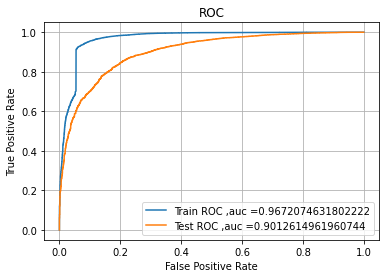

In [69]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_pred_bow)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_bow_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_bow))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test, y_pred_bow_test))))

plt.title('ROC')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

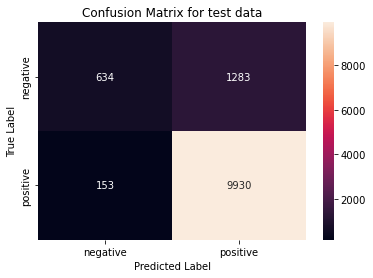

In [70]:
# confusion Matrix for test data
y_pred_bow_test = model_rbf_bow.predict(X_test_bow)

confusion = confusion_matrix(y_test, y_pred_bow_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 6. RBF-SVM - TFIDF


In [71]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_val)

scaler = StandardScaler(with_mean=False)
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)
X_val_tfidf = scaler.transform(X_val_tfidf)

### 6.1 Hyperparameter Tuning


In [72]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
parameter_grid = {'C': C}

In [73]:
model = SVC()

rbf_tfidf_model = HalvingGridSearchCV(model, parameter_grid, scoring='roc_auc', cv=10, verbose=3)

rbf_tfidf_model.fit(X_train_tfidf, y_train)
print('Best Hyperparameters --> ', rbf_tfidf_model.best_params_)
print('Best Accuracy --> ', rbf_tfidf_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2177
max_resources_: 19600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 2177
Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END .....C=0.0001;, score=(train=0.811, test=0.752) total time=   0.1s
[CV 2/10] END .....C=0.0001;, score=(train=0.793, test=0.705) total time=   0.1s
[CV 3/10] END .....C=0.0001;, score=(train=0.795, test=0.752) total time=   0.1s
[CV 4/10] END .....C=0.0001;, score=(train=0.823, test=0.705) total time=   0.1s
[CV 5/10] END .....C=0.0001;, score=(train=0.818, test=0.695) total time=   0.1s
[CV 6/10] END .....C=0.0001;, score=(train=0.764, test=0.705) total time=   0.0s
[CV 7/10] END .....C=0.0001;, score=(train=0.816, test=0.704) total time=   0.1s
[CV 8/10] END .....C=0.0001;, score=(train=0.820, test=0.652) total time=   0.0s
[CV 9/10] END .....C=0.0001;, score=(train=0.799, test=0.728) total time=   0.0s
[CV 10/1

### 6.2 Model Building (RBF-TFIDF)

In [74]:
model_rbf_tfidf = SVC(C=rbf_tfidf_model.best_estimator_.C, probability=True)

model_rbf_tfidf.fit(X_train_tfidf, y_train)

# predicted values for train & test data
y_pred_tfidf = model_rbf_tfidf.decision_function(X_train_tfidf)
y_pred_tfidf_test = model_rbf_tfidf.decision_function(X_test_tfidf)

### 6.3 Model Evaluation (RBF-TFIDF)


In [75]:
print('Accuracy of RBF-TFIDF model : ',model_rbf_tfidf.score(X_test_tfidf, y_test))

Accuracy of RBF-TFIDF model :  0.8909166666666667


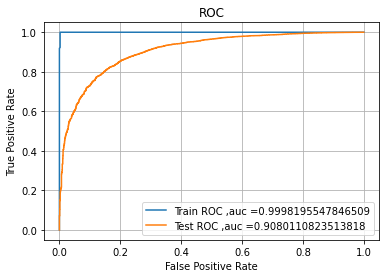

In [76]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(
    y_train, y_pred_tfidf)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(
    y_test, y_pred_tfidf_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1,
        label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_tfidf))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(
    str(roc_auc_score(y_test, y_pred_tfidf_test))))

plt.title('ROC')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

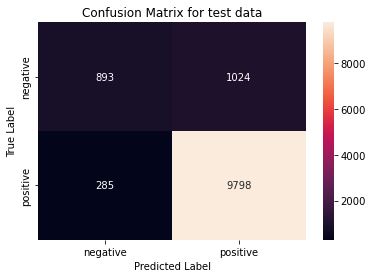

In [77]:
# confusion Matrix for test data
y_pred_tfidf_test = model_rbf_tfidf.predict(X_test_tfidf)

confusion = confusion_matrix(y_test, y_pred_tfidf_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 7. RBF-SVM - AVG-W2V


In [78]:
#word2vec for train data

sent_list_train = []
sent_vectors_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())

w2v_model = Word2Vec(sent_list_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_train.append(sent_vectors)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 19600/19600 [00:12<00:00, 1535.83it/s]

19600
50


In [79]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []
sent_vectors_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_val.append(sent_vectors)

print(len(sent_vectors_val))
print(len(sent_vectors_val[0]))

100%|██████████| 8400/8400 [00:05<00:00, 1533.02it/s]

8400
50


In [80]:
#word2vec for test data

sent_list_test = []
sent_vectors_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

for sent in tqdm(sent_list_test):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_test.append(sent_vectors)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 12000/12000 [00:08<00:00, 1492.89it/s]

12000
50


In [81]:
X_train_avg_w2v = sent_vectors_train
X_val_avg_w2v = sent_vectors_val
X_test_avg_w2v = sent_vectors_test

### 7.1 Hyperparameter Tuning


In [82]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
parameter_grid = {'C': C}

In [83]:
model = SVC()

rbf_avg_w2v_model = HalvingGridSearchCV(model, parameter_grid, scoring='roc_auc', cv=10, verbose=3)

rbf_avg_w2v_model.fit(X_train_avg_w2v, y_train)
print('Best Hyperparameters --> ', rbf_avg_w2v_model.best_params_)
print('Best Accuracy --> ', rbf_avg_w2v_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2177
max_resources_: 19600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 2177
Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END .....C=0.0001;, score=(train=0.780, test=0.734) total time=   0.0s
[CV 2/10] END .....C=0.0001;, score=(train=0.774, test=0.754) total time=   0.0s
[CV 3/10] END .....C=0.0001;, score=(train=0.747, test=0.663) total time=   0.0s
[CV 4/10] END .....C=0.0001;, score=(train=0.760, test=0.710) total time=   0.0s
[CV 5/10] END .....C=0.0001;, score=(train=0.768, test=0.784) total time=   0.0s
[CV 6/10] END .....C=0.0001;, score=(train=0.749, test=0.737) total time=   0.0s
[CV 7/10] END .....C=0.0001;, score=(train=0.793, test=0.815) total time=   0.0s
[CV 8/10] END .....C=0.0001;, score=(train=0.754, test=0.660) total time=   0.0s
[CV 9/10] END .....C=0.0001;, score=(train=0.750, test=0.763) total time=   0.0s
[CV 10/1

### 7.2 Model Building (RBF-AVG-W2V)

In [84]:
model_rbf_avg_w2v = SVC(C=rbf_avg_w2v_model.best_estimator_.C, probability=True)

model_rbf_avg_w2v.fit(X_train_avg_w2v, y_train)

# predicted values for train & test data
y_pred_avg_w2v = model_rbf_avg_w2v.decision_function(X_train_avg_w2v)
y_pred_avg_w2v_test = model_rbf_avg_w2v.decision_function(X_test_avg_w2v)

### 7.3 Model Evaluation (RBF-AVG-W2V)


In [85]:
print('Accuracy of RBF-AVG-W2V model : ',model_rbf_avg_w2v.score(X_test_avg_w2v, y_test))

Accuracy of RBF-AVG-W2V model :  0.8724166666666666


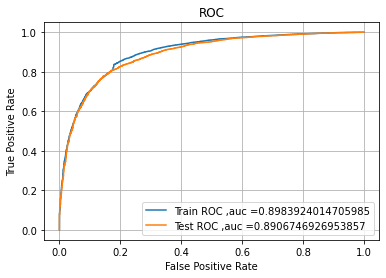

In [86]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(
    y_train, y_pred_avg_w2v)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(
    y_test, y_pred_avg_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(
    str(roc_auc_score(y_train, y_pred_avg_w2v))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(
    str(roc_auc_score(y_test, y_pred_avg_w2v_test))))

plt.title('ROC')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

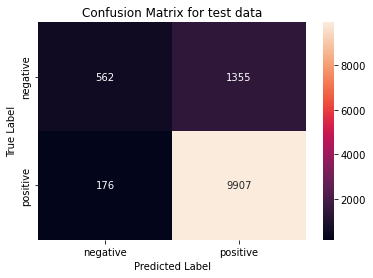

In [87]:
# confusion Matrix for test data
y_pred_avg_w2v_test = model_rbf_avg_w2v.predict(X_test_avg_w2v)

confusion = confusion_matrix(y_test, y_pred_avg_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 8. RBF-SVM - TFIDF-W2V


In [88]:
sent_list_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())

w2v_model = Word2Vec(sent_list_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


tfidf_vectors = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_features=500)
tfidf_matrix = tfidf_vectors.fit_transform(X_train)

tfidf_features = tfidf_vectors.get_feature_names()
tfidf_dictionary = dict(zip(tfidf_vectors.get_feature_names(), list(tfidf_vectors.idf_)))


#word2vec for train data

tfidf_sent_vectors_train = []
row = 0

for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    weight_sum = 0

    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf)
            weight_sum += tfidf

    if weight_sum != 0:
        sent_vectors /= weight_sum

    tfidf_sent_vectors_train.append(sent_vectors)
    row += 1

100%|██████████| 19600/19600 [00:15<00:00, 1252.47it/s]


In [89]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

tfidf_sent_vectors_val = []
row = 0

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_val.append(sent_vectors)
    row +=1

100%|██████████| 8400/8400 [00:06<00:00, 1235.51it/s]


In [90]:
#word2vec for test data

sent_list_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

tfidf_sent_vectors_test = []
row=0
    
for sent in tqdm(sent_list_test):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_test.append(sent_vectors)
    row +=1

100%|██████████| 12000/12000 [00:09<00:00, 1216.77it/s]


In [91]:
X_train_tfidf_w2v = tfidf_sent_vectors_train
X_val_tfidf_w2v = tfidf_sent_vectors_val
X_test_tfidf_w2v = tfidf_sent_vectors_test

### 8.1 Hyperparameter Tuning

In [92]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
parameter_grid = {'C': C}

In [93]:
model = SVC()

rbf_tfidf_w2v_model = HalvingGridSearchCV(model, parameter_grid, scoring='roc_auc', cv=10, verbose=3)

rbf_tfidf_w2v_model.fit(X_train_tfidf_w2v, y_train)
print('Best Hyperparameters --> ', rbf_tfidf_w2v_model.best_params_)
print('Best Accuracy --> ', rbf_tfidf_w2v_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2177
max_resources_: 19600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 2177
Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END .....C=0.0001;, score=(train=0.683, test=0.669) total time=   0.0s
[CV 2/10] END .....C=0.0001;, score=(train=0.725, test=0.703) total time=   0.0s
[CV 3/10] END .....C=0.0001;, score=(train=0.710, test=0.657) total time=   0.0s
[CV 4/10] END .....C=0.0001;, score=(train=0.716, test=0.665) total time=   0.0s
[CV 5/10] END .....C=0.0001;, score=(train=0.741, test=0.703) total time=   0.0s
[CV 6/10] END .....C=0.0001;, score=(train=0.730, test=0.710) total time=   0.0s
[CV 7/10] END .....C=0.0001;, score=(train=0.730, test=0.735) total time=   0.0s
[CV 8/10] END .....C=0.0001;, score=(train=0.678, test=0.682) total time=   0.0s
[CV 9/10] END .....C=0.0001;, score=(train=0.716, test=0.659) total time=   0.0s
[CV 10/1

### 8.2 Model Building (RBF-TFIDF-W2V)


In [94]:
model_rbf_tfidf_w2v = SVC(C=rbf_tfidf_w2v_model.best_estimator_.C, probability=True)

model_rbf_tfidf_w2v.fit(X_train_avg_w2v, y_train)

# predicted values for train & test data
y_pred_tfidf_w2v = model_rbf_tfidf_w2v.decision_function(X_train_tfidf_w2v)
y_pred_tfidf_w2v_test = model_rbf_tfidf_w2v.decision_function(X_test_tfidf_w2v)

### 8.3 Model Evaluation (RBF-TFIDF-W2V)


In [95]:
print('Accuracy of RBF-TFIDF-W2V model : ',model_rbf_tfidf_w2v.score(X_test_tfidf_w2v, y_test))

Accuracy of RBF-TFIDF-W2V model :  0.8536666666666667


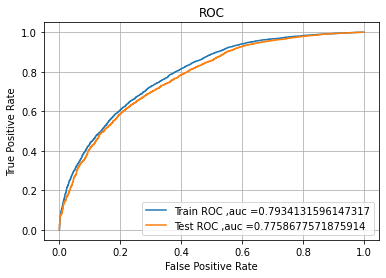

In [96]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(
    y_train, y_pred_tfidf_w2v)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(
    y_test, y_pred_tfidf_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_tfidf_w2v))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test, y_pred_tfidf_w2v_test))))

plt.title('ROC')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

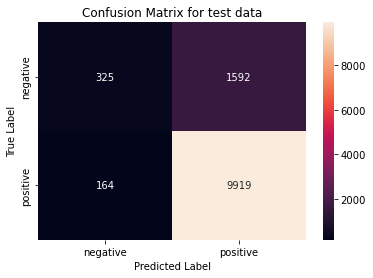

In [97]:
# confusion Matrix for test data
y_pred_tfidf_w2v_test = model_rbf_tfidf_w2v.predict(X_test_tfidf_w2v)

confusion = confusion_matrix(y_test, y_pred_tfidf_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Model Comparision

## Creating a prettytable to see which model performed better

### 1. Linear SVM

In [101]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = 'Linear SVM'

x.field_names = ['Vectorizer', 'Best Hyperparameters', 'AUC']
x.add_row(['BOW', {'alpha': 0.1, 'penalty': 'l2'}, 0.89201])
x.add_row(['TFIDF', {'alpha': 0.0001, 'penalty': 'l2'}, 0.95372])
x.add_row(['AVG-W2V', {'alpha': 0.001, 'penalty': 'l2'}, 0.89476])
x.add_row(['TFIDF-W2V', {'alpha': 0.01, 'penalty': 'l2'}, 0.83663])

x.sortby = 'AUC'
x.reversesort = True
print(x)

+-----------------------------------------------------------+
|                         Linear SVM                        |
+------------+------------------------------------+---------+
| Vectorizer |        Best Hyperparameters        |   AUC   |
+------------+------------------------------------+---------+
|   TFIDF    | {'alpha': 0.0001, 'penalty': 'l2'} | 0.95372 |
|  AVG-W2V   | {'alpha': 0.001, 'penalty': 'l2'}  | 0.89476 |
|    BOW     |  {'alpha': 0.1, 'penalty': 'l2'}   | 0.89201 |
| TFIDF-W2V  |  {'alpha': 0.01, 'penalty': 'l2'}  | 0.83663 |
+------------+------------------------------------+---------+


### 2. RBF SVM

In [100]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = 'RBF SVM'

x.field_names = ['Vectorizer', 'Best Hyperparameter', 'AUC']
x.add_row(['BOW', {'C': 1}, 0.90126])
x.add_row(['TFIDF', {'C': 10000}, 0.90801])
x.add_row(['AVG-W2V', {'C': 1}, 0.89067])
x.add_row(['TFIDF-W2V', {'C': 1}, 0.77586])

x.sortby = 'AUC'
x.reversesort = True
print(x)


+--------------------------------------------+
|                  RBF SVM                   |
+------------+---------------------+---------+
| Vectorizer | Best Hyperparameter |   AUC   |
+------------+---------------------+---------+
|   TFIDF    |     {'C': 10000}    | 0.90801 |
|    BOW     |       {'C': 1}      | 0.90126 |
|  AVG-W2V   |       {'C': 1}      | 0.89067 |
| TFIDF-W2V  |       {'C': 1}      | 0.77586 |
+------------+---------------------+---------+
